In [2]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.data.pytorch_dataset import MaskingDataset
import numpy as np
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from torchvision.transforms import v2


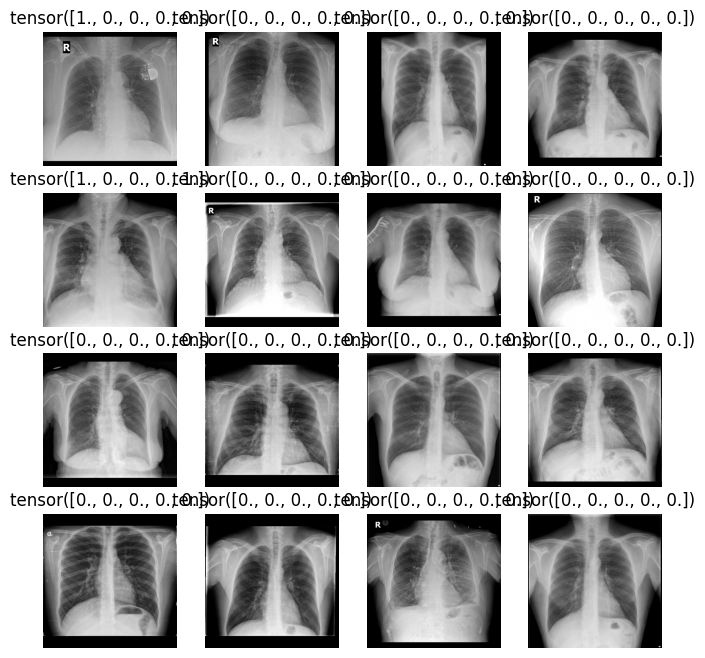

In [3]:
data = MaskingDataset(data_dir="../data/processed",masking_spread=None,inverse_roi=False)
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx]
    img = img.permute(1,2,0)
    figure.add_subplot(rows, cols, i)
    label = torch.FloatTensor(label)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
data.img_labels[data.img_labels["ImageID"].isin(["96782236244536831763179434394056352962_rztevf.png"])]["Onehot"]

7957    [1, 0, 0, 0, 0]
Name: Onehot, dtype: object

In [5]:
print(len(data))

7379


In [6]:
lst_labels = []
for l in data.img_labels["Onehot"]:
    lst_labels.append(l)
np.sum(lst_labels,axis=0)

array([676, 309,  83,  14, 219])

## Splitting

In [7]:
transforms = v2.Compose([
        v2.RandomRotation(degrees=45),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=(0.7,1.1))
    ])

train_data = MaskingDataset(data_dir="../data/processed",transform=None,masking_spread=0,inverse_roi=True, bounding_box=True)
val_data = MaskingDataset(data_dir="../data/processed")
test_data = MaskingDataset(data_dir="../data/processed")

#Split train and the rest (val+test)
splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state = 1907)
train_eval_split = splitter.split(train_data.img_labels, groups=train_data.img_labels['PatientID'])
train_idx, eval_idx = next(train_eval_split)
train_data.img_labels = train_data.img_labels.iloc[train_idx].reset_index(drop=True)
train_data.img_paths = np.array(train_data.img_paths)[train_idx]
train_data.roi_paths = np.array(train_data.roi_paths)[train_idx]

val_data.img_labels = val_data.img_labels.iloc[eval_idx].reset_index(drop=True)
val_data.img_paths = np.array(val_data.img_paths)[eval_idx]
val_data.roi_paths = np.array(val_data.roi_paths)[eval_idx]

#Split val and test
splitter = GroupShuffleSplit(test_size=0.5, n_splits=2, random_state = 1907)
val_test_split = splitter.split(val_data.img_labels, groups=val_data.img_labels['PatientID'])
val_idx, test_idx = next(val_test_split)

test_data.img_labels = val_data.img_labels.iloc[test_idx]
test_data.img_paths = np.array(val_data.img_paths)[test_idx]
test_data.roi_paths = np.array(val_data.roi_paths)[test_idx]

val_data.img_labels = val_data.img_labels.iloc[val_idx]
val_data.img_paths = np.array(val_data.img_paths)[val_idx]
val_data.roi_paths = np.array(val_data.roi_paths)[val_idx]

BATCH_SIZE = 16
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)
torch.save(train_dataloader,"../data/processed/dataloader/train_dataloader.pth")
torch.save(valid_dataloader,"../data/processed/dataloader/valid_dataloader.pth")
torch.save(test_dataloader,"../data/processed/dataloader/test_dataloader.pth")

In [8]:
len(train_data),len(val_data),len(test_data)

(5895, 751, 733)

In [9]:
train_data.img_labels[train_data.img_labels["ImageID"].isin(["96782236244536831763179434394056352962_rztevf.png"])]["Onehot"]

5867    [1, 0, 0, 0, 0]
Name: Onehot, dtype: object

torch.Size([16, 3, 512, 512])


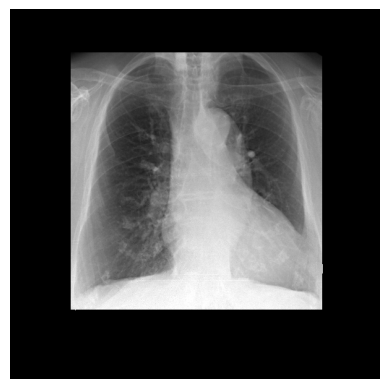

In [10]:
for i, data in enumerate(train_dataloader, 0):
    inputs, labels = data
    print(inputs.shape)
    inputs,labels = inputs.float(), torch.Tensor(np.array(labels)).float()
    plt.imshow(inputs.permute(0,2,3,1)[0],cmap="gray")
    plt.axis("off")
    break